<div align="center">

# PyTorch CNN Image Classification with Patra Model Cards

</div>

This notebook demonstrates how to use the **Patra Toolkit** to document a PyTorch Convolutional Neural Network (CNN) trained for image classification. The Patra Toolkit provides a structured approach to creating model cards that capture essential metadata about AI/ML models, including their purpose, architecture, performance metrics, and requirements.

---

This notebook demonstrates:

1. **Loading & Preprocessing** the CIFAR-10 Image Dataset
2. **Building & Training** a CNN using PyTorch
3. **Creating a Model Card** with model metadata and metrics
4. **Submitting** the Model Card (and optionally the model) to:
   - **Patra server** (for model card storage)
   - **Backend** (Hugging Face or GitHub) for model storage

---

## 1. Environment Setup

In [10]:
!pip install patra-toolkit

In [11]:
!pip install torch torchvision numpy matplotlib

In [12]:
import logging

# Suppress verbose logging
logging.getLogger("huggingface_hub").setLevel(logging.ERROR)
logging.getLogger("PyGithub").setLevel(logging.ERROR)

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from patra_toolkit import ModelCard, AIModel

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Load and Pre-process the CIFAR-10 Dataset

We'll use the **CIFAR-10** dataset, a widely used benchmark for image classification containing 60,000 32x32 color images in 10 classes:
- airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

The full dataset has 50,000 training images and 10,000 test images. For this tutorial, we'll use a **subset of 10,000 training samples** to reduce training time.

In [13]:
# Define CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Define data transformations
# - ToTensor: Converts PIL image to PyTorch tensor and scales to [0, 1]
# - Normalize: Normalizes with mean and std for each RGB channel
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomCrop(32, padding=4),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Download and load CIFAR-10 dataset
train_dataset_full = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

# Use a subset of training data for faster training (10,000 samples instead of 50,000)
from torch.utils.data import Subset
train_subset_size = 10000
train_indices = torch.randperm(len(train_dataset_full))[:train_subset_size]
train_dataset = Subset(train_dataset_full, train_indices)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)} (subset of {len(train_dataset_full)})")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(class_names)}")

Training samples: 10000 (subset of 50000)
Test samples: 10000
Number of classes: 10


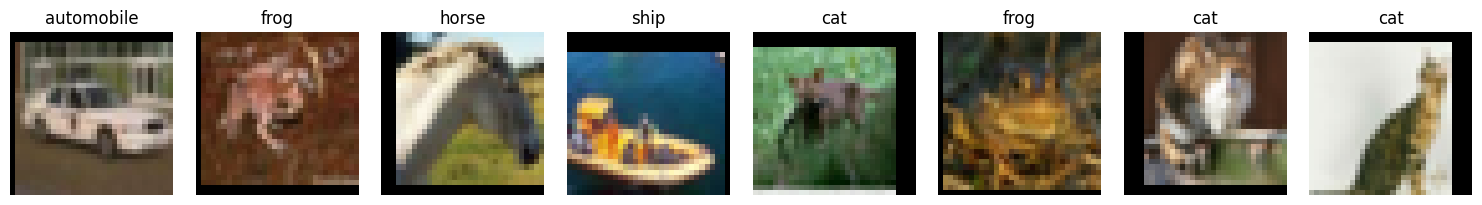

In [14]:
# Visualize some sample images from the dataset
def show_images(images, labels, num_images=8):
    """Display a grid of sample images with their labels."""
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))
    for i in range(num_images):
        # Denormalize the image for display
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2470, 0.2435, 0.2616])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
show_images(images, labels)

## 3. Define the CNN Architecture

We'll build a Convolutional Neural Network with the following architecture:
- **3 Convolutional blocks** (each with Conv2D → BatchNorm → ReLU → MaxPool)
- **2 Fully connected layers** for classification
- **Dropout** for regularization

This is a simple but effective architecture for CIFAR-10 classification.

In [15]:
class CIFAR10CNN(nn.Module):
    """
    A Convolutional Neural Network for CIFAR-10 image classification.
    
    Architecture:
    - 3 convolutional blocks with batch normalization
    - 2 fully connected layers
    - Dropout for regularization
    """
    
    def __init__(self, num_classes=10):
        super(CIFAR10CNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Instantiate the model
model = CIFAR10CNN(num_classes=10).to(device)

# Print model summary
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

CIFAR10CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )

## 4. Train the Model

We'll train the CNN using:
- **Cross-Entropy Loss** for multi-class classification
- **Adam optimizer** with learning rate scheduling
- **Reduced dataset** (10,000 samples) and **5 epochs** for faster training in this tutorial

In [16]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training parameters (reduced for faster training)
num_epochs = 5
best_accuracy = 0.0

# Training history
train_losses = []
train_accuracies = []
test_accuracies = []

In [17]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100.0 * correct / total
    return epoch_loss, epoch_accuracy


def evaluate(model, test_loader, device):
    """Evaluate the model on the test set."""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100.0 * correct / total
    return accuracy

In [18]:
# Training loop
print("Starting training...\n")

for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate on test set
    test_acc = evaluate(model, test_loader, device)
    
    # Update learning rate
    scheduler.step()
    
    # Save history
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    # Save best model
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        torch.save(model.state_dict(), 'best_cifar10_cnn.pt')
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}%, "
          f"Test Acc: {test_acc:.2f}%")

print(f"\nTraining complete! Best test accuracy: {best_accuracy:.2f}%")

Starting training...

Epoch [1/5] Train Loss: 1.8046, Train Acc: 32.95%, Test Acc: 41.46%
Epoch [2/5] Train Loss: 1.4962, Train Acc: 44.32%, Test Acc: 52.04%
Epoch [3/5] Train Loss: 1.3110, Train Acc: 52.34%, Test Acc: 59.83%
Epoch [4/5] Train Loss: 1.1241, Train Acc: 60.11%, Test Acc: 64.82%
Epoch [5/5] Train Loss: 1.0567, Train Acc: 61.88%, Test Acc: 66.19%

Training complete! Best test accuracy: 66.19%


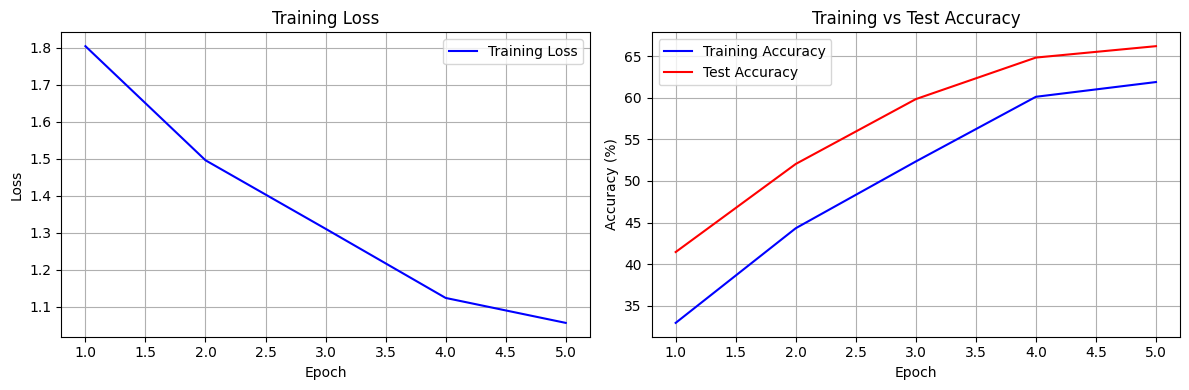

In [19]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(range(1, num_epochs + 1), test_accuracies, 'r-', label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training vs Test Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 5. Evaluate Model Performance

Let's evaluate the trained model in more detail, including per-class accuracy and confusion matrix.

In [20]:
# Load best model weights
model.load_state_dict(torch.load('best_cifar10_cnn.pt'))
model.eval()

# Final test accuracy
test_accuracy = evaluate(model, test_loader, device)
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Final Test Accuracy: 66.19%


In [21]:
# Calculate per-class accuracy
class_correct = [0] * 10
class_total = [0] * 10

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        for i in range(labels.size(0)):
            label = labels[i].item()
            class_total[label] += 1
            if predicted[i] == labels[i]:
                class_correct[label] += 1

print("Per-class accuracy:")
print("-" * 35)
for i in range(10):
    accuracy = 100.0 * class_correct[i] / class_total[i]
    print(f"{class_names[i]:>12}: {accuracy:.2f}%")

Per-class accuracy:
-----------------------------------
    airplane: 75.10%
  automobile: 81.50%
        bird: 45.10%
         cat: 36.30%
        deer: 57.90%
         dog: 60.70%
        frog: 78.70%
       horse: 68.30%
        ship: 77.50%
       truck: 80.80%


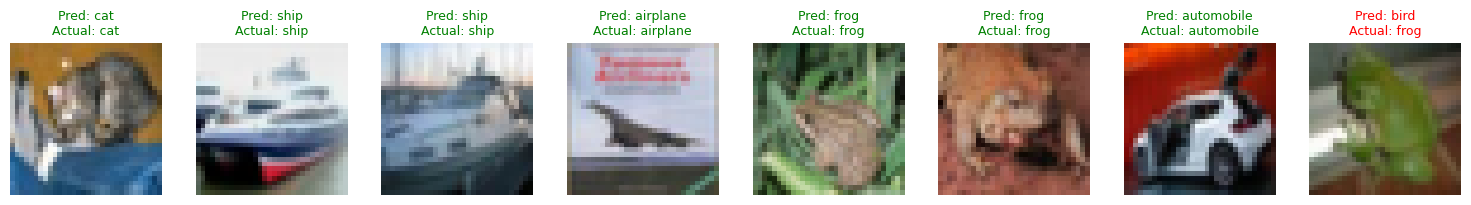

In [22]:
# Visualize some predictions
def show_predictions(model, test_loader, device, num_images=8):
    """Display sample predictions with their actual and predicted labels."""
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    with torch.no_grad():
        outputs = model(images.to(device))
        _, predicted = outputs.max(1)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))
    for i in range(num_images):
        # Denormalize image
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2470, 0.2435, 0.2616])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        color = 'green' if predicted[i] == labels[i] else 'red'
        axes[i].set_title(f"Pred: {class_names[predicted[i]]}\nActual: {class_names[labels[i]]}",
                          color=color, fontsize=9)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_predictions(model, test_loader, device)

## 6. Building a Patra Model Card

Now that we have a trained model, let's create a **Patra Model Card** to document all the important information about our model.

### 6.1 Basic Model Card Setup

We start with essential metadata like name, version, description, and other key information.

In [23]:
mc = ModelCard(
    name="CIFAR10_PyTorch_CNN",
    version="1.0",
    short_description="PyTorch CNN for CIFAR-10 image classification.",
    full_description=(
        "This is a Convolutional Neural Network (CNN) built with PyTorch for classifying "
        "images from the CIFAR-10 dataset. The model uses 3 convolutional blocks with "
        "batch normalization and dropout for regularization. It can classify images into "
        "10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. "
        "This notebook demonstrates how to use Patra Toolkit to create comprehensive model cards "
        "for PyTorch models."
    ),
    keywords="cifar-10, pytorch, cnn, image classification, deep learning, computer vision",
    author="Patra Toolkit User",
    input_type="Image",
    category="classification",
    citation="Krizhevsky, A. (2009). Learning Multiple Layers of Features from Tiny Images. Technical Report."
)

# Set input/output data references
mc.input_data = "https://www.cs.toronto.edu/~kriz/cifar.html"
mc.output_data = ""  # Will be updated after model upload

### 6.2 Attach AI Model Information

Here we describe the model's architecture, ownership, license, performance metrics, etc.

In [24]:
ai_model = AIModel(
    name="CIFAR10_CNN_PyTorch",
    version="1.0",
    description="CNN with 3 convolutional blocks for CIFAR-10 image classification",
    owner="Patra Toolkit User",
    location="",  # Will be updated after model upload
    license="BSD-3-Clause",
    framework="pytorch",
    model_type="cnn",
    test_accuracy=test_accuracy / 100.0  # Convert percentage to decimal
)

# Add additional training and performance metrics
ai_model.add_metric("Epochs", num_epochs)
ai_model.add_metric("Batch Size", batch_size)
ai_model.add_metric("Optimizer", "Adam")
ai_model.add_metric("Learning Rate", 0.001)
ai_model.add_metric("LR Scheduler", "StepLR (step=10, gamma=0.1)")
ai_model.add_metric("Input Shape", "3x32x32")
ai_model.add_metric("Number of Classes", 10)
ai_model.add_metric("Total Parameters", sum(p.numel() for p in model.parameters()))
ai_model.add_metric("Best Test Accuracy", f"{best_accuracy:.2f}%")

# Note: populate_model_structure is designed for TensorFlow models.
# For PyTorch, we'll document the structure manually in the description.

mc.ai_model = ai_model
print("AI Model metadata attached successfully.")

AI Model metadata attached successfully.


### 6.3 Important Note on Fairness and Explainability for Image Classification

**Bias Analysis**: The `populate_bias()` method in Patra Toolkit is designed for tabular data where protected attributes (like gender, race, etc.) can be explicitly identified. For image classification tasks like CIFAR-10, traditional fairness metrics may not directly apply since the data doesn't contain explicit demographic information. However, researchers working on specialized image datasets (e.g., facial recognition) should consider fairness analysis.

**Explainability (XAI)**: The current `populate_xai()` method uses SHAP which works well with tabular data. For CNNs, specialized visualization techniques like:
- Grad-CAM (Gradient-weighted Class Activation Mapping)
- Saliency Maps
- Layer-wise Relevance Propagation

are more appropriate but require custom implementation. We'll skip these analyses for this tutorial, but you can extend the model card with custom explainability results.

## 7. Add Requirements

We let Patra auto-detect Python package dependencies to ensure reproducibility.

In [25]:
mc.populate_requirements()
print(f"Captured {len(mc.model_requirements)} package dependencies.")

Captured 86 package dependencies.


## 8. Validate and Preview the Model Card

In [26]:
# Validate the model card against the schema
is_valid = mc.validate()
print(f"Model Card is valid: {is_valid}")

INFO:root:Model card validation successful.


Model Card is valid: True


In [27]:
# Preview the model card (first part)
import json
mc_dict = json.loads(str(mc))

# Print key fields (excluding large requirements list)
preview = {k: v for k, v in mc_dict.items() if k != 'model_requirements'}
print(json.dumps(preview, indent=2))

{
  "name": "CIFAR10_PyTorch_CNN",
  "version": "1.0",
  "short_description": "PyTorch CNN for CIFAR-10 image classification.",
  "full_description": "This is a Convolutional Neural Network (CNN) built with PyTorch for classifying images from the CIFAR-10 dataset. The model uses 3 convolutional blocks with batch normalization and dropout for regularization. It can classify images into 10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. This notebook demonstrates how to use Patra Toolkit to create comprehensive model cards for PyTorch models.",
  "keywords": "cifar-10, pytorch, cnn, image classification, deep learning, computer vision",
  "author": "Patra Toolkit User",
  "input_type": "Image",
  "category": "classification",
  "citation": "Krizhevsky, A. (2009). Learning Multiple Layers of Features from Tiny Images. Technical Report.",
  "input_data": "https://www.cs.toronto.edu/~kriz/cifar.html",
  "output_data": "",
  "foundational_model": "",
  "

## 9. Save and Submit the Model Card

### 9.1 Save Model Card Locally

First, let's save the model card to a JSON file.

In [28]:
# Save the model card locally
mc.save("PyTorch_CIFAR10_CNN_MC.json")
print("Model card saved to PyTorch_CIFAR10_CNN_MC.json")

INFO:root:Model card created.


Model card saved to PyTorch_CIFAR10_CNN_MC.json


### 9.2 Create Inference Labels File

Create a labels file that can be used during model inference.

In [29]:
# Create inference labels file
with open("cifar10_labels.txt", "w") as f:
    for label in class_names:
        f.write(f"{label}\n")

print("Labels file created: cifar10_labels.txt")

Labels file created: cifar10_labels.txt


### 9.3 Submit to Patra Server (Optional)

**[Optional] Tapis Authentication:**  
Before submitting, ensure you have obtained a valid Tapis token using your TACC credentials. If you do not already have a TACC account, you can create one at [https://accounts.tacc.utexas.edu/begin](https://accounts.tacc.utexas.edu/begin).

The `mc.submit(...)` method can:
1. **Submit only the card** (no model, no artifacts)
2. **Include the trained model** (uploading to Hugging Face or GitHub)
3. **Add artifacts** (data files, inference labels, etc.)

In [30]:
# Uncomment to authenticate with Tapis
# tapis_token = mc.authenticate(username="your_username", password="your_password")

In [31]:
# Submit model card only (without model upload)
# patra_server_url = "http://127.0.0.1:5002"
# mc.submit(patra_server_url=patra_server_url)  # Add token=tapis_token if using authentication

In [32]:
# Submit model card with model to Hugging Face
# mc.version = "1.1"
# mc.submit(
#     patra_server_url=patra_server_url,
#     model=model,
#     file_format="pt",  # PyTorch format
#     model_store="huggingface"
# )

In [33]:
# Submit with model, inference labels, and artifacts
# mc.version = "1.2"
# mc.submit(
#     patra_server_url=patra_server_url,
#     model=model,
#     file_format="pt",
#     model_store="huggingface",
#     inference_labels="cifar10_labels.txt",
#     artifacts=["PyTorch_CIFAR10_CNN_MC.json"]
# )

## 10. Model Inference Example

Finally, let's demonstrate how to load the saved model and perform inference on new images.

In [34]:
def predict_image(model, image_tensor, device):
    """
    Make a prediction for a single image.
    
    Args:
        model: Trained PyTorch model
        image_tensor: Preprocessed image tensor
        device: Device to run inference on
    
    Returns:
        Tuple of (predicted_class_name, confidence_score, all_probabilities)
    """
    model.eval()
    with torch.no_grad():
        # Add batch dimension if needed
        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0)
        
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = probabilities.max(1)
        
        return (
            class_names[predicted.item()],
            confidence.item() * 100,
            {class_names[i]: prob.item() * 100 for i, prob in enumerate(probabilities[0])}
        )

# Example: Predict on a test image
test_iter = iter(test_loader)
test_images, test_labels = next(test_iter)

# Predict first image
predicted_class, confidence, all_probs = predict_image(model, test_images[0], device)
actual_class = class_names[test_labels[0].item()]

print(f"Actual class: {actual_class}")
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")
print(f"\nAll class probabilities:")
for cls, prob in sorted(all_probs.items(), key=lambda x: -x[1])[:5]:
    print(f"  {cls}: {prob:.2f}%")

Actual class: cat
Predicted class: cat
Confidence: 63.74%

All class probabilities:
  cat: 63.74%
  dog: 15.25%
  ship: 8.63%
  frog: 8.14%
  bird: 1.29%


## Summary

In this notebook, you have:

1. **Loaded and preprocessed** the CIFAR-10 image dataset using PyTorch's torchvision
2. **Built a CNN architecture** with convolutional blocks, batch normalization, and dropout
3. **Trained the model** using Adam optimizer and learning rate scheduling
4. **Evaluated performance** including overall accuracy and per-class metrics
5. **Created a Patra Model Card** documenting:
   - Model metadata (name, version, description)
   - AI model details (framework, architecture, performance)
   - Training hyperparameters and metrics
   - Package requirements for reproducibility
6. **Saved the model card** locally and demonstrated submission options

The Patra Toolkit helps maintain transparency and reproducibility in ML workflows by standardizing model documentation.